# Machine Learning 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from tqdm import tqdm
from pathlib import Path

#ignore warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 10)

In [64]:
train = pd.read_csv(r"train/train.csv")
train.head(10)

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429
5,1640671020,22264866
6,288840453,34952168
7,1162441568,9504818
8,1791400073,11719563
9,2059516238,11629084


### How many ms a count

In [3]:
time = 50

In [4]:
def readFileLogic(index):
    if(index) == 0:
        return False
    if(index+(time-1)) %time == 0:
        return False
    return True

# Feature Engineering 1-Using interpolate to deal with the missing value

In [5]:
def dealWithNA(df):
    df.interpolate(method='linear', axis=0, inplace=True)
    return df

# Feature Engineering 2- the ZScore of the data

In [6]:
from sklearn.preprocessing import StandardScaler
def Z_Score(df):
    MaxZScore = []
    MinZScore = []
    MaxDifInSecond = []
    diff = pd.DataFrame()
    
    for i in range(1,11):
        sensor = StandardScaler().fit_transform(df.loc[: ,['sensor_' + str(i)]].values)
        diff = pd.DataFrame(sensor)
        diff['sensor'] = diff
        diff['diff'] = abs(diff['sensor'] - diff['sensor'].shift(1))
        MaxZScore.append(sensor.max())
        MinZScore.append(sensor.min())
        MaxDifInSecond.append(diff['diff'].max())
        
    df = df.T
    df['MaxZScore'] = MaxZScore
    df['MinZScore'] = MinZScore
    df['MaxDifZScore'] = df['MaxZScore'] - df['MinZScore']
    df['MaxDifInSecond'] = MaxDifInSecond    
    df = df.T
    
    return df

# Feature Engineering 3 - Aggregations and group statistics

In [7]:
def aggregation(df):
    df = df.T    
    df['AvgMaxZScore'] = df['MaxZScore'].mean()
    df['MaxZScoreStd'] = df['MaxZScore'].std()
    df['MaxZScore_level'] = (df['MaxZScore']-df['AvgMaxZScore'])/df['MaxZScoreStd']
    
    df['AvgMinZScore'] = df['MinZScore'].mean()
    df['MinZScoreStd'] = df['MinZScore'].std()
    df['MinZScore_level'] = (df['MinZScore']-df['AvgMinZScore'])/df['MinZScoreStd']
    
    df['AvgMaxDifZScore'] = df['MaxDifZScore'].mean()
    df['MaxDifZScoreStd'] = df['MaxDifZScore'].std()
    df['MaxDifZScore_level'] = (df['MaxDifZScore']-df['AvgMaxDifZScore'])/df['MaxDifZScoreStd']
    
    df['AvgMaxDifInSecond'] = df['MaxDifInSecond'].mean()
    df['MaxDifInSecondStd'] = df['MaxDifInSecond'].std()
    df['MaxDifInSecond_level'] = (df['MaxDifInSecond']-df['AvgMaxDifInSecond'])/df['MaxDifInSecondStd']
    df = df.T
    
    return df

# Feature Engineering 4 - Scaling

In [8]:
def normalization(df):
    df = df.T
    df['MaxZScoreNormalized'] = (df['MaxZScore'] - df['MaxZScore'].min()) / (df['MaxZScore'].max() - df['MaxZScore'].min())
    df['MinZScoreNormalized'] = (df['MinZScore'] - df['MinZScore'].min()) / (df['MinZScore'].max() - df['MinZScore'].min())
    df['MaxDifZScoreNormalized'] = (df['MaxDifZScore'] - df['MaxDifZScore'].min()) / (df['MaxDifZScore'].max() - df['MaxDifZScore'].min())
    df['MaxDifInSecondNormalized'] = (df['MaxDifInSecond'] - df['MaxDifInSecond'].min()) / (df['MaxDifInSecond'].max() - df['MaxDifInSecond'].min())
    df = df.T
    
    return df

# Feature Engineering 5 - Binning

In [9]:
def setbin(df):
    df = df.T
    df['AvgMaxZScore_bin'] = np.digitize(df['AvgMaxZScore'], bins=[0,1,2,3,4,5,6,7,8,9,10])
    df['AvgMinZScore_bin'] = np.digitize(df['AvgMinZScore'], bins=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
    df['AvgMaxDifZScore_bin'] = np.digitize(df['AvgMaxDifZScore'], bins=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
    df['AvgMaxDifInSecond_bin'] = np.digitize(df['AvgMaxDifInSecond'], bins=[5,6,7,8,9,10,11,12,13,14,15])
    df = df.T
    
    return df

In [10]:
def data_agg(df):
    data = df.iloc[0:int(60000/time+1)]
    data = data.fillna(0)
    skew = data.agg(['skew'])
    skew = skew.stack()
    skew = skew.values.reshape(-1,1)
    
    Min = data.agg(['min'])
    Min = Min.stack()
    Min = Min.values.reshape(-1,1)
    
    Std = data.agg(['std'])
    Std = Std.stack()
    Std = Std.values.reshape(-1,1)
    
    mean = data.agg(['mean'])
    mean = mean.stack()
    mean = mean.values.reshape(-1,1)
    
    kurtosis = data.agg(['kurtosis'])
    kurtosis = kurtosis.stack()
    kurtosis = kurtosis.values.reshape(-1,1)
    
    df = df.T
    df['maxskew'] = skew.max()
    df['min'] = Min
    df['std'] = Std
    df['mean'] = mean
    df['maxkurtosis'] = kurtosis.max()
    df = df.T
    return df

# New Feature creation

In [11]:
def feature_creation(df, idx):
    df = dealWithNA(df)
    df = Z_Score(df)      
    df = data_agg(df)
    df = aggregation(df)
    df = normalization(df)
    df = setbin(df) 
    df = df.add_prefix(idx + '_')    
    df = df.T  
    df['segment_id'] = int(idx)
    df.drop(df.iloc[:,0:int(60000/time+1)], axis=1, inplace=True)
    return df

# collecting all data in one frame

In [12]:
df = pd.DataFrame()
for csv in tqdm(Path(r"train/data").glob("**/*.csv"), total=4431):
    read = pd.read_csv(csv, skiprows= lambda x: readFileLogic(x))
    df = df.append(feature_creation(read, csv.stem))
df.isnull().mean()

100%|██████████| 4431/4431 [09:18<00:00,  7.93it/s]


MaxZScore                   0.063575
MinZScore                   0.063575
MaxDifZScore                0.063575
MaxDifInSecond              0.056849
maxskew                     0.000000
min                         0.000000
std                         0.000000
mean                        0.000000
maxkurtosis                 0.000000
AvgMaxZScore                0.000000
MaxZScoreStd                0.000000
MaxZScore_level             0.063575
AvgMinZScore                0.000000
MinZScoreStd                0.000000
MinZScore_level             0.063575
AvgMaxDifZScore             0.000000
MaxDifZScoreStd             0.000000
MaxDifZScore_level          0.063575
AvgMaxDifInSecond           0.000000
MaxDifInSecondStd           0.000000
MaxDifInSecond_level        0.056849
MaxZScoreNormalized         0.063575
MinZScoreNormalized         0.063575
MaxDifZScoreNormalized      0.063575
MaxDifInSecondNormalized    0.056849
AvgMaxZScore_bin            0.000000
AvgMinZScore_bin            0.000000
A

Checking all null value

In [13]:
df.dropna(axis=0, inplace=True)
df.isnull().mean()

MaxZScore                   0.0
MinZScore                   0.0
MaxDifZScore                0.0
MaxDifInSecond              0.0
maxskew                     0.0
min                         0.0
std                         0.0
mean                        0.0
maxkurtosis                 0.0
AvgMaxZScore                0.0
MaxZScoreStd                0.0
MaxZScore_level             0.0
AvgMinZScore                0.0
MinZScoreStd                0.0
MinZScore_level             0.0
AvgMaxDifZScore             0.0
MaxDifZScoreStd             0.0
MaxDifZScore_level          0.0
AvgMaxDifInSecond           0.0
MaxDifInSecondStd           0.0
MaxDifInSecond_level        0.0
MaxZScoreNormalized         0.0
MinZScoreNormalized         0.0
MaxDifZScoreNormalized      0.0
MaxDifInSecondNormalized    0.0
AvgMaxZScore_bin            0.0
AvgMinZScore_bin            0.0
AvgMaxDifZScore_bin         0.0
AvgMaxDifInSecond_bin       0.0
segment_id                  0.0
dtype: float64

### Variance check

In [14]:
df.var()

MaxZScore                   3.645838e+00
MinZScore                   3.559452e+00
MaxDifZScore                1.153416e+01
MaxDifInSecond              1.057010e+01
maxskew                     1.491397e+00
min                         1.765927e+07
std                         1.975383e+06
mean                        2.935196e+03
maxkurtosis                 1.562232e+03
AvgMaxZScore                1.027991e+00
MaxZScoreStd                9.403844e-01
MaxZScore_level             8.932324e-01
AvgMinZScore                9.920837e-01
MinZScoreStd                8.954319e-01
MinZScore_level             8.932324e-01
AvgMaxDifZScore             3.726967e+00
MaxDifZScoreStd             2.463109e+00
MaxDifZScore_level          8.932324e-01
AvgMaxDifInSecond           3.522461e+00
MaxDifInSecondStd           2.200263e+00
MaxDifInSecond_level        8.896574e-01
MaxZScoreNormalized         1.068257e-01
MinZScoreNormalized         1.067647e-01
MaxDifZScoreNormalized      1.065544e-01
MaxDifInSecondNo

* We found that the MaxZScoreNormalized, MinZScoreNormalized, MaxDifZScoreNormalized, MaxDifInSecondNormalized is much less than others
* So we drop them

In [15]:
df.var()

MaxZScore                   3.645838e+00
MinZScore                   3.559452e+00
MaxDifZScore                1.153416e+01
MaxDifInSecond              1.057010e+01
maxskew                     1.491397e+00
min                         1.765927e+07
std                         1.975383e+06
mean                        2.935196e+03
maxkurtosis                 1.562232e+03
AvgMaxZScore                1.027991e+00
MaxZScoreStd                9.403844e-01
MaxZScore_level             8.932324e-01
AvgMinZScore                9.920837e-01
MinZScoreStd                8.954319e-01
MinZScore_level             8.932324e-01
AvgMaxDifZScore             3.726967e+00
MaxDifZScoreStd             2.463109e+00
MaxDifZScore_level          8.932324e-01
AvgMaxDifInSecond           3.522461e+00
MaxDifInSecondStd           2.200263e+00
MaxDifInSecond_level        8.896574e-01
MaxZScoreNormalized         1.068257e-01
MinZScoreNormalized         1.067647e-01
MaxDifZScoreNormalized      1.065544e-01
MaxDifInSecondNo

In [16]:
df.drop(['MaxZScoreNormalized','MinZScoreNormalized','MaxDifZScoreNormalized','MaxDifInSecondNormalized'], axis=1, inplace=True)
df

,MaxZScore,MinZScore,MaxDifZScore,MaxDifInSecond,maxskew,min,std,mean,maxkurtosis,AvgMaxZScore,...,MaxDifZScoreStd,MaxDifZScore_level,AvgMaxDifInSecond,MaxDifInSecondStd,MaxDifInSecond_level,AvgMaxZScore_bin,AvgMinZScore_bin,AvgMaxDifZScore_bin,AvgMaxDifInSecond_bin,segment_id
288431696_sensor_1,6.019470,-5.626582,11.646052,10.444874,0.338139,-1579.0,279.008972,-9.786844,78.679614,5.875748,...,5.645955,-0.107482,10.34688,4.718272,0.020769,6.0,4.0,8.0,6.0,288431696
288431696_sensor_3,5.655473,-5.287995,10.943469,10.943469,0.338139,-1231.0,232.747104,-0.746878,78.679614,5.875748,...,5.645955,-0.231923,10.34688,4.718272,0.126442,6.0,4.0,8.0,6.0,288431696
288431696_sensor_4,5.953183,-3.532241,9.485425,8.244017,0.338139,-1324.0,374.730733,-0.911740,78.679614,5.875748,...,5.645955,-0.490168,10.34688,4.718272,-0.445685,6.0,4.0,8.0,6.0,288431696
288431696_sensor_5,5.310437,-4.593669,9.904106,8.974118,0.338139,-867.0,190.404393,7.290591,78.679614,5.875748,...,5.645955,-0.416012,10.34688,4.718272,-0.290946,6.0,4.0,8.0,6.0,288431696
288431696_sensor_6,3.513707,-5.053311,8.567018,4.384382,0.338139,-1404.0,277.691801,-1.321399,78.679614,5.875748,...,5.645955,-0.652835,10.34688,4.718272,-1.263704,6.0,4.0,8.0,6.0,288431696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788555372_sensor_6,3.030076,-3.772637,6.802713,5.886354,0.902938,-3463.0,914.868999,-12.968360,103.271888,7.921349,...,8.115618,-1.315919,15.25345,7.772643,-1.205137,8.0,1.0,13.0,11.0,1788555372
1788555372_sensor_7,5.350031,-6.585465,11.935496,11.935496,0.902938,-4440.0,677.505757,19.832639,103.271888,7.921349,...,8.115618,-0.683462,15.25345,7.772643,-0.426876,8.0,1.0,13.0,11.0,1788555372
1788555372_sensor_8,3.847611,-3.364872,7.212482,5.409053,0.902938,-2708.0,810.460779,17.960866,103.271888,7.921349,...,8.115618,-1.265428,15.25345,7.772643,-1.266544,8.0,1.0,13.0,11.0,1788555372
1788555372_sensor_9,10.187111,-9.374052,19.561163,13.687411,0.902938,-5387.0,573.977894,-8.741882,103.271888,7.921349,...,8.115618,0.256167,15.25345,7.772643,-0.201481,8.0,1.0,13.0,11.0,1788555372


### Merge with the train.csv

In [17]:
df = df.merge(train, on='segment_id')
df

,MaxZScore,MinZScore,MaxDifZScore,MaxDifInSecond,maxskew,min,std,mean,maxkurtosis,AvgMaxZScore,...,MaxDifZScore_level,AvgMaxDifInSecond,MaxDifInSecondStd,MaxDifInSecond_level,AvgMaxZScore_bin,AvgMinZScore_bin,AvgMaxDifZScore_bin,AvgMaxDifInSecond_bin,segment_id,time_to_eruption
0,6.019470,-5.626582,11.646052,10.444874,0.338139,-1579.0,279.008972,-9.786844,78.679614,5.875748,...,-0.107482,10.34688,4.718272,0.020769,6.0,4.0,8.0,6.0,288431696,15253621
1,5.655473,-5.287995,10.943469,10.943469,0.338139,-1231.0,232.747104,-0.746878,78.679614,5.875748,...,-0.231923,10.34688,4.718272,0.126442,6.0,4.0,8.0,6.0,288431696,15253621
2,5.953183,-3.532241,9.485425,8.244017,0.338139,-1324.0,374.730733,-0.911740,78.679614,5.875748,...,-0.490168,10.34688,4.718272,-0.445685,6.0,4.0,8.0,6.0,288431696,15253621
3,5.310437,-4.593669,9.904106,8.974118,0.338139,-867.0,190.404393,7.290591,78.679614,5.875748,...,-0.416012,10.34688,4.718272,-0.290946,6.0,4.0,8.0,6.0,288431696,15253621
4,3.513707,-5.053311,8.567018,4.384382,0.338139,-1404.0,277.691801,-1.321399,78.679614,5.875748,...,-0.652835,10.34688,4.718272,-1.263704,6.0,4.0,8.0,6.0,288431696,15253621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41488,3.030076,-3.772637,6.802713,5.886354,0.902938,-3463.0,914.868999,-12.968360,103.271888,7.921349,...,-1.315919,15.25345,7.772643,-1.205137,8.0,1.0,13.0,11.0,1788555372,44853667
41489,5.350031,-6.585465,11.935496,11.935496,0.902938,-4440.0,677.505757,19.832639,103.271888,7.921349,...,-0.683462,15.25345,7.772643,-0.426876,8.0,1.0,13.0,11.0,1788555372,44853667
41490,3.847611,-3.364872,7.212482,5.409053,0.902938,-2708.0,810.460779,17.960866,103.271888,7.921349,...,-1.265428,15.25345,7.772643,-1.266544,8.0,1.0,13.0,11.0,1788555372,44853667
41491,10.187111,-9.374052,19.561163,13.687411,0.902938,-5387.0,573.977894,-8.741882,103.271888,7.921349,...,0.256167,15.25345,7.772643,-0.201481,8.0,1.0,13.0,11.0,1788555372,44853667


# Two technique for Dimensionality Reduction

# 1. Decision Tree (Random Forest) Feature Importances

In [18]:
from sklearn.ensemble import RandomForestRegressor
feature = df.drop(['segment_id','time_to_eruption'], axis=1)
feature

,MaxZScore,MinZScore,MaxDifZScore,MaxDifInSecond,maxskew,min,std,mean,maxkurtosis,AvgMaxZScore,...,AvgMaxDifZScore,MaxDifZScoreStd,MaxDifZScore_level,AvgMaxDifInSecond,MaxDifInSecondStd,MaxDifInSecond_level,AvgMaxZScore_bin,AvgMinZScore_bin,AvgMaxDifZScore_bin,AvgMaxDifInSecond_bin
0,6.019470,-5.626582,11.646052,10.444874,0.338139,-1579.0,279.008972,-9.786844,78.679614,5.875748,...,12.252893,5.645955,-0.107482,10.34688,4.718272,0.020769,6.0,4.0,8.0,6.0
1,5.655473,-5.287995,10.943469,10.943469,0.338139,-1231.0,232.747104,-0.746878,78.679614,5.875748,...,12.252893,5.645955,-0.231923,10.34688,4.718272,0.126442,6.0,4.0,8.0,6.0
2,5.953183,-3.532241,9.485425,8.244017,0.338139,-1324.0,374.730733,-0.911740,78.679614,5.875748,...,12.252893,5.645955,-0.490168,10.34688,4.718272,-0.445685,6.0,4.0,8.0,6.0
3,5.310437,-4.593669,9.904106,8.974118,0.338139,-867.0,190.404393,7.290591,78.679614,5.875748,...,12.252893,5.645955,-0.416012,10.34688,4.718272,-0.290946,6.0,4.0,8.0,6.0
4,3.513707,-5.053311,8.567018,4.384382,0.338139,-1404.0,277.691801,-1.321399,78.679614,5.875748,...,12.252893,5.645955,-0.652835,10.34688,4.718272,-1.263704,6.0,4.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41488,3.030076,-3.772637,6.802713,5.886354,0.902938,-3463.0,914.868999,-12.968360,103.271888,7.921349,...,17.482211,8.115618,-1.315919,15.25345,7.772643,-1.205137,8.0,1.0,13.0,11.0
41489,5.350031,-6.585465,11.935496,11.935496,0.902938,-4440.0,677.505757,19.832639,103.271888,7.921349,...,17.482211,8.115618,-0.683462,15.25345,7.772643,-0.426876,8.0,1.0,13.0,11.0
41490,3.847611,-3.364872,7.212482,5.409053,0.902938,-2708.0,810.460779,17.960866,103.271888,7.921349,...,17.482211,8.115618,-1.265428,15.25345,7.772643,-1.266544,8.0,1.0,13.0,11.0
41491,10.187111,-9.374052,19.561163,13.687411,0.902938,-5387.0,573.977894,-8.741882,103.271888,7.921349,...,17.482211,8.115618,0.256167,15.25345,7.772643,-0.201481,8.0,1.0,13.0,11.0


In [19]:
Y = pd.DataFrame(df['segment_id'])
Y['time_to_eruption'] = df['time_to_eruption']
Y

,segment_id,time_to_eruption
0,288431696,15253621
1,288431696,15253621
2,288431696,15253621
3,288431696,15253621
4,288431696,15253621
...,...,...
41488,1788555372,44853667
41489,1788555372,44853667
41490,1788555372,44853667
41491,1788555372,44853667


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(feature, Y, test_size=0.3, random_state=120)

In [21]:
model = RandomForestRegressor(random_state=10, max_depth=30)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [22]:
dict(reversed(sorted(zip(model.feature_importances_, df.columns.values))))

{0.11759578843600228: 'MaxDifInSecondStd',
 0.10817040111049087: 'maxskew',
 0.10568522215735367: 'maxkurtosis',
 0.09925733025890565: 'AvgMaxDifInSecond',
 0.09891381817685148: 'MaxDifZScoreStd',
 0.09791619024790106: 'MinZScoreStd',
 0.09701419615431932: 'MaxZScoreStd',
 0.09224285881745833: 'AvgMaxZScore',
 0.08328241601910895: 'AvgMinZScore',
 0.0731117532664546: 'AvgMaxDifZScore',
 0.006004831677872054: 'AvgMaxDifInSecond_bin',
 0.003820104941188107: 'AvgMaxDifZScore_bin',
 0.003569029782501736: 'std',
 0.0029529177961874833: 'AvgMinZScore_bin',
 0.002671407447436431: 'AvgMaxZScore_bin',
 0.0024734227594754377: 'min',
 0.0012342978721384438: 'mean',
 0.0006201929525625682: 'MaxDifInSecond',
 0.0006188395070139942: 'MaxZScore',
 0.0005605923909384261: 'MinZScore',
 0.0005279187064584307: 'MinZScore_level',
 0.0004922528601184591: 'MaxDifInSecond_level',
 0.000437414081611954: 'MaxDifZScore_level',
 0.00041924082462117823: 'MaxZScore_level',
 0.00040756175502930554: 'MaxDifZScore'}

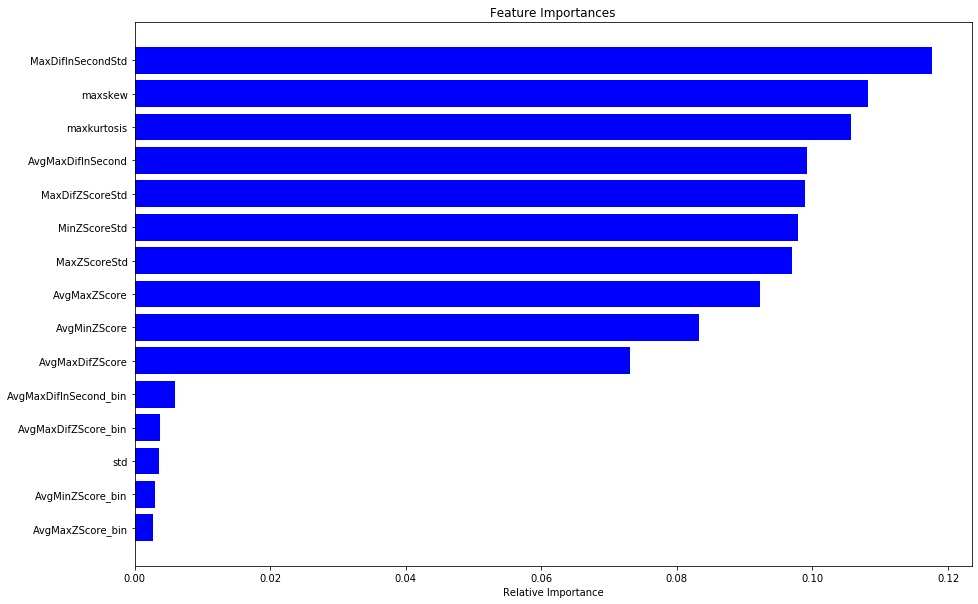

In [23]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [24]:
indices

array([21, 22,  6, 23, 24, 15, 12,  9, 10, 13, 16, 18,  8,  4, 19])

In [25]:
model.score(X_test, Y_test)

0.9544610633089

In [26]:
y_pred = model.predict(X_test)
y_pred

array([[1.75999801e+09, 3.03857028e+07],
       [1.09986799e+09, 3.09086117e+07],
       [3.71846087e+08, 2.75061765e+07],
       ...,
       [6.05871853e+08, 1.70951684e+07],
       [4.65840118e+08, 2.49513671e+07],
       [3.05100753e+08, 2.07416839e+07]])

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
print("MAE test score:", mean_absolute_error(Y_test, y_pred))
print("MSE test score:", mean_squared_error(Y_test, y_pred))
print("RMSE test score:", sqrt(mean_squared_error(Y_test, y_pred)))

MAE test score: 51131373.49868169
MSE test score: 8615569502471689.0
RMSE test score: 92820092.12703729


In [28]:
X = df.iloc[:,indices]
X

,AvgMaxZScore_bin,AvgMinZScore_bin,std,AvgMaxDifZScore_bin,AvgMaxDifInSecond_bin,AvgMaxDifZScore,AvgMinZScore,AvgMaxZScore,MaxZScoreStd,MinZScoreStd,MaxDifZScoreStd,AvgMaxDifInSecond,maxkurtosis,maxskew,MaxDifInSecondStd
0,6.0,4.0,279.008972,8.0,6.0,12.252893,-6.377145,5.875748,1.558458,4.363829,5.645955,10.34688,78.679614,0.338139,4.718272
1,6.0,4.0,232.747104,8.0,6.0,12.252893,-6.377145,5.875748,1.558458,4.363829,5.645955,10.34688,78.679614,0.338139,4.718272
2,6.0,4.0,374.730733,8.0,6.0,12.252893,-6.377145,5.875748,1.558458,4.363829,5.645955,10.34688,78.679614,0.338139,4.718272
3,6.0,4.0,190.404393,8.0,6.0,12.252893,-6.377145,5.875748,1.558458,4.363829,5.645955,10.34688,78.679614,0.338139,4.718272
4,6.0,4.0,277.691801,8.0,6.0,12.252893,-6.377145,5.875748,1.558458,4.363829,5.645955,10.34688,78.679614,0.338139,4.718272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41488,8.0,1.0,914.868999,13.0,11.0,17.482211,-9.560862,7.921349,3.743458,5.015572,8.115618,15.25345,103.271888,0.902938,7.772643
41489,8.0,1.0,677.505757,13.0,11.0,17.482211,-9.560862,7.921349,3.743458,5.015572,8.115618,15.25345,103.271888,0.902938,7.772643
41490,8.0,1.0,810.460779,13.0,11.0,17.482211,-9.560862,7.921349,3.743458,5.015572,8.115618,15.25345,103.271888,0.902938,7.772643
41491,8.0,1.0,573.977894,13.0,11.0,17.482211,-9.560862,7.921349,3.743458,5.015572,8.115618,15.25345,103.271888,0.902938,7.772643


In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=120)

In [30]:
model = RandomForestRegressor(random_state=1, max_depth=30)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [31]:
model.score(X_test, Y_test)

0.9620505626308649

In [32]:
y_pred = model.predict(X_test)
y_pred

array([[1.74939735e+09, 2.98428931e+07],
       [1.07325870e+09, 3.21774253e+07],
       [3.69145596e+08, 2.80202520e+07],
       ...,
       [5.67960798e+08, 1.65502904e+07],
       [5.37704517e+08, 2.46647865e+07],
       [2.52536908e+08, 1.99009094e+07]])

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
print("MAE test score:", mean_absolute_error(Y_test, y_pred))
print("MSE test score:", mean_squared_error(Y_test, y_pred))
print("RMSE test score:", sqrt(mean_squared_error(Y_test, y_pred)))

MAE test score: 46531945.95673736
MSE test score: 7179702447847896.0
RMSE test score: 84733124.8559139


# 2.Principal Component Analysis(PCA)

In [42]:
from sklearn.preprocessing import StandardScaler
x = feature
y = df['time_to_eruption']
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x)
x

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.782281,-0.583717,0.764079,1.076726,-0.240042,0.314569,-0.310381,-0.181915,1.529995,1.331463,...,1.658509,2.000926,-0.113726,1.809139,1.534139,0.021510,0.940718,-1.910121,1.766624,1.904412
1,0.591645,-0.404251,0.557203,1.230086,-0.240042,0.397382,-0.343297,-0.015054,1.529995,1.331463,...,1.658509,2.000926,-0.245395,1.809139,1.534139,0.133547,0.940718,-1.910121,1.766624,1.904412
2,0.747564,0.526380,0.127881,0.399775,-0.240042,0.375251,-0.242274,-0.018097,1.529995,1.331463,...,1.658509,2.000926,-0.518643,1.809139,1.534139,-0.473031,0.940718,-1.910121,1.766624,1.904412
3,0.410939,-0.036226,0.251162,0.624343,-0.240042,0.484003,-0.373424,0.133302,1.529995,1.331463,...,1.658509,2.000926,-0.440179,1.809139,1.534139,-0.308974,0.940718,-1.910121,1.766624,1.904412
4,-0.530060,-0.279857,-0.142544,-0.787392,-0.240042,0.356214,-0.311318,-0.025659,1.529995,1.331463,...,1.658509,2.000926,-0.690758,1.809139,1.534139,-1.340307,0.940718,-1.910121,1.766624,1.904412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41488,-0.783351,0.398959,-0.662044,-0.325408,0.222448,-0.133763,0.142038,-0.240639,2.152197,3.349047,...,4.367282,3.574550,-1.392362,4.423467,3.593298,-1.278213,2.840376,-4.800555,4.323856,4.607736
41489,0.431676,-1.091969,0.849306,1.535219,0.222448,-0.366258,-0.026848,0.364804,2.152197,3.349047,...,4.367282,3.574550,-0.723165,4.423467,3.593298,-0.453089,2.840376,-4.800555,4.323856,4.607736
41490,-0.355185,0.615094,-0.541388,-0.472219,0.222448,0.045903,0.067751,0.330255,2.152197,3.349047,...,4.367282,3.574550,-1.338938,4.423467,3.593298,-1.343318,2.840376,-4.800555,4.323856,4.607736
41491,2.964995,-2.570049,3.094686,2.074083,0.222448,-0.591613,-0.100508,-0.162627,2.152197,3.349047,...,4.367282,3.574550,0.271048,4.423467,3.593298,-0.214122,2.840376,-4.800555,4.323856,4.607736


In [37]:
from sklearn.decomposition import PCA
pca = PCA()
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)
x_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,5.951142,-1.117783,-0.254646,-1.078523,-1.466909,1.312947,-1.002819,0.575950,0.182028,-0.245255,...,0.004429,0.089005,-0.056834,0.367655,0.007443,-0.108901,-0.019540,0.122530,-1.544241e-14,4.615200e-14
1,5.853709,-1.372422,-0.314166,-1.064479,-1.375702,1.447345,-0.888736,0.567314,0.480806,-0.429100,...,-0.009215,0.048387,-0.171295,0.350503,0.063531,-0.147748,0.015491,0.119888,-4.868615e-15,-2.191731e-14
2,5.382521,-2.353382,-0.177740,-0.961069,-1.145820,1.319418,-1.661416,0.549187,-0.130708,-0.600823,...,-0.153334,0.097555,-0.078471,0.332268,-0.075019,-0.096927,-0.021919,0.120466,-1.764333e-16,4.377327e-17
3,5.509308,-2.177503,-0.331958,-1.030922,-1.272179,1.553683,-0.914338,0.524500,0.109176,-0.502422,...,-0.050999,0.097213,-0.050343,0.336473,0.066375,-0.117598,-0.012786,0.121886,-2.946393e-15,-4.775407e-16
4,4.871366,-3.741085,-0.084297,-1.332347,-1.742080,1.606759,0.232400,0.362987,-0.777914,-0.331429,...,-0.035570,0.282555,0.449865,0.321265,0.285964,-0.027423,-0.111034,0.129278,-4.310455e-15,-4.106576e-16


In [38]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([4.72631887e-01, 1.95841186e-01, 7.73714338e-02, 5.95205644e-02,
       4.05571543e-02, 3.96868904e-02, 2.95469039e-02, 1.88355136e-02,
       1.38800671e-02, 1.28112034e-02, 9.74261776e-03, 7.13977060e-03,
       4.57757565e-03, 4.28929963e-03, 3.70477226e-03, 2.66726966e-03,
       2.11255619e-03, 1.43117463e-03, 9.65601931e-04, 9.60069526e-04,
       6.98684221e-04, 5.73264074e-04, 4.54539977e-04, 1.28483377e-32,
       3.24362649e-33])

In [39]:
np.cumsum(pca.explained_variance_ratio_)

array([0.47263189, 0.66847307, 0.74584451, 0.80536507, 0.84592223,
       0.88560912, 0.91515602, 0.93399153, 0.9478716 , 0.9606828 ,
       0.97042542, 0.97756519, 0.98214277, 0.98643207, 0.99013684,
       0.99280411, 0.99491667, 0.99634784, 0.99731344, 0.99827351,
       0.9989722 , 0.99954546, 1.        , 1.        , 1.        ])

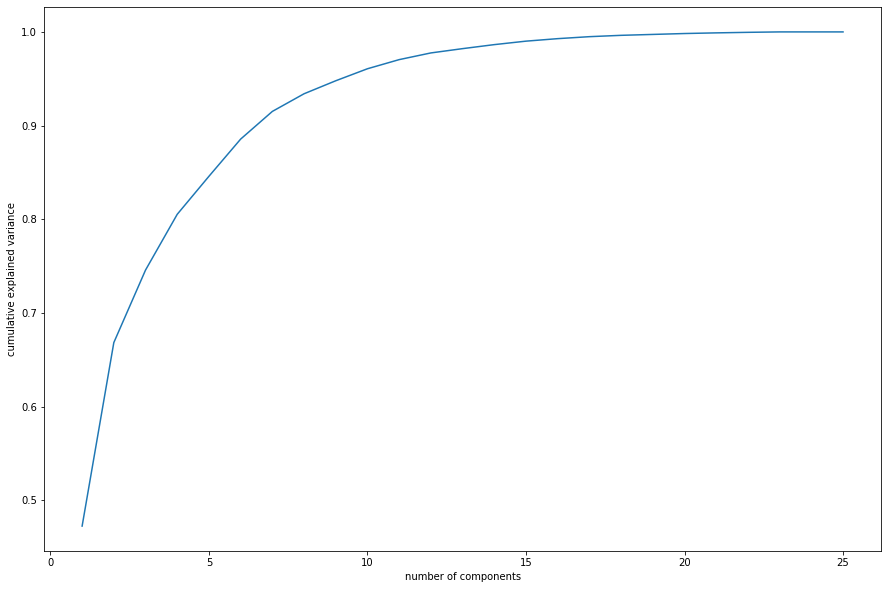

In [41]:
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [44]:
x_pca['target']=y
x_pca.columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21','PC22','PC23','PC24','PC25','target']
x_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,target
0,5.951142,-1.117783,-0.254646,-1.078523,-1.466909,1.312947,-1.002819,0.575950,0.182028,-0.245255,...,0.089005,-0.056834,0.367655,0.007443,-0.108901,-0.019540,0.122530,-1.544241e-14,4.615200e-14,15253621
1,5.853709,-1.372422,-0.314166,-1.064479,-1.375702,1.447345,-0.888736,0.567314,0.480806,-0.429100,...,0.048387,-0.171295,0.350503,0.063531,-0.147748,0.015491,0.119888,-4.868615e-15,-2.191731e-14,15253621
2,5.382521,-2.353382,-0.177740,-0.961069,-1.145820,1.319418,-1.661416,0.549187,-0.130708,-0.600823,...,0.097555,-0.078471,0.332268,-0.075019,-0.096927,-0.021919,0.120466,-1.764333e-16,4.377327e-17,15253621
3,5.509308,-2.177503,-0.331958,-1.030922,-1.272179,1.553683,-0.914338,0.524500,0.109176,-0.502422,...,0.097213,-0.050343,0.336473,0.066375,-0.117598,-0.012786,0.121886,-2.946393e-15,-4.775407e-16,15253621
4,4.871366,-3.741085,-0.084297,-1.332347,-1.742080,1.606759,0.232400,0.362987,-0.777914,-0.331429,...,0.282555,0.449865,0.321265,0.285964,-0.027423,-0.111034,0.129278,-4.310455e-15,-4.106576e-16,15253621


In [62]:
y_uni = y.unique()
y_uni
# targets = [15253621,32793795,22938880]
# y_uni.size

array([15253621, 32793795, 22938880, ..., 30514691, 27256080, 44853667])

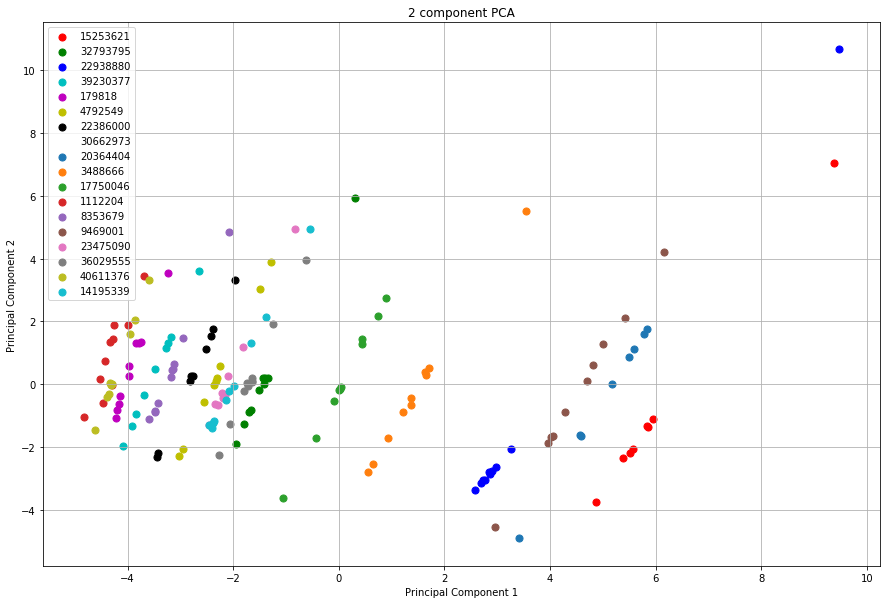

In [63]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1') 
ax.set_ylabel('Principal Component 2') 
ax.set_title('2 component PCA') 
targets = y_uni
colors = ['r','g','b','c','m','y','k','w','tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
for target, color in zip(targets,colors):
     indicesToKeep = x_pca['target'] == target
     ax.scatter(x_pca.loc[indicesToKeep,'PC1']
         ,x_pca.loc[indicesToKeep,'PC2']
         ,c = color
         ,s = 50)
ax.legend(targets)
ax.grid()

## 4. Unsupervised learning models

# Model 1 - K-means

In [ ]:
feature.head()

In [ ]:
X = feature[['MaxDifInSecondStd','maxskew']] 

In [ ]:
plt.scatter(X['MaxDifInSecondStd'], X['maxskew'],s=10)

In [ ]:
from sklearn.cluster import KMeans, MeanShift, DBSCAN
wx = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(X)
    wx.append(kmeans.inertia_)
plt.plot(range(1, 11), wx)
plt.xlabel('Number of clusters')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
n=6
kmeans=KMeans(n_clusters=n, random_state=20).fit(X)
labels_of_clusters = kmeans.fit_predict(X)

In [ ]:
labels_of_clusters

In [ ]:
kmeans.inertia_

In [ ]:
plt.scatter(X['MaxDifInSecondStd'], X['maxskew'], s=10, c=kmeans.predict(X))

# Model - 2 Meanshift

In [ ]:
X = feature[['maxkurtosis','AvgMaxDifInSecond']] 

In [ ]:
plt.scatter(X['maxkurtosis'], X['AvgMaxDifInSecond'],s=10)

In [ ]:
ms = MeanShift()

In [ ]:
ms.fit(X) 

In [ ]:
plt.scatter(X['maxkurtosis'], X['AvgMaxDifInSecond'],s=10, c=ms.predict(X))

# Model 3- Hierarchial Clustering

In [ ]:
X = feature[['MaxDifZScoreStd','MinZScoreStd']] 

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
agc = AgglomerativeClustering(linkage='single')

In [ ]:
agc.fit(X)

In [ ]:
plt.scatter(X['MaxDifZScoreStd'], X['MinZScoreStd'],s=10,c=agc.labels_)

# Model 4 - Density Based Clustering - DBSCAN

In [ ]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [ ]:
# plt.scatter(X['MaxDifZScoreStd'], X['MinZScoreStd'],s=10,c=labels)
plt.scatter(X[:,0], X[:,1],s=10,c=labels)

### Until now, I think K-means clustering is more useful for the features we have.

# Supervised Learning Models

# Model 1- KNN

In [ ]:
df

In [ ]:
X=df.drop(['time_to_eruption'],axis=1)
Y=df.time_to_eruption

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn.fit(X_train,y_train)

In [ ]:
y_pred = knn.predict(X_test)
y_pred

# Model Evaluation

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score

In [ ]:
print(confusion_matrix(y_test,y_pred))

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
accuracy_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,X,Y,cv=10)
    accuracy_rate.append(score.mean())

In [ ]:
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,X,Y,cv=10)
    error_rate.append(1-score.mean())

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(range(1,40),accuracy_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
        markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print('WITH K=1')
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

In [ ]:

knn = KNeighborsClassifier(n_neighbors=19)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print('WITH K=19')
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

# Model 2 - Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [ ]:
model.fit(X_train,y_train)

In [ ]:
model.score(X_test,y_test)

In [ ]:
y_test[0:10]

In [ ]:
model.predict(X_test[0:10])

In [ ]:
model.predict_proba(X_test)

# Model Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(GaussianNB(),X_train, y_train, cv=4,scoring='accuracy').mean())

# XgBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
X=df.drop(['time_to_eruption'],axis=1)
Y=df.time_to_eruption

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()